### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [3]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!pip install transformers
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-03-01 09:46:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-01 09:46:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-01 09:46:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import transformers
from keras.preprocessing.sequence import pad_sequences
import re
import math
import torch.nn.functional as F

In [2]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# Load data
train_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/train.csv')
dev_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/dev.csv')
test_df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Imperial - NLP/data/test.csv')

In [5]:
# replace original word with edited word
def get_edited_df(df):
    df_copy = df.copy(deep=True)
    df_copy['edited'] = df_copy['original']
    df_copy['edited'] = df_copy.apply(lambda x: re.sub(r"(<[^>]+>)", x['edit'], x['edited']), axis=1)
    return df_copy

In [5]:
train_df = get_edited_df(train_df)
dev_df = get_edited_df(dev_df)
test_df = get_edited_df(test_df)

In [6]:
# Datasets for approach 2
edited_train_df = get_edited_df(train_df)
edited_dev_df = get_edited_df(dev_df)
edited_test_df = get_edited_df(test_df)

In [10]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

# batch_size
BATCH_SIZE = 32

In [11]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, method=None, filename=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    if method == 'bert':
        train_loss = []
        eval_loss = []

        for epoch in range(1, number_epoch+1):
            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0

            for batch in train_iter:
                feature, target, mask = batch
                
                feature, target, mask = feature.to(device), target.to(device), mask.to(device)
                model.batch_size = target.shape[0]
                no_observations += target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                optimizer.zero_grad()
                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
            
            valid_loss, valid_mse, __, __ = eval(dev_iter, model, method=method)

            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
            
            train_loss += [epoch_loss]
            eval_loss += [valid_loss]
            
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
        torch.save(model.state_dict(), './drive/MyDrive/NLP_CW/bert.pth')
        np.save('./drive/MyDrive/NLP_CW/train_loss.npy', train_loss)
        np.save('./drive/MyDrive/NLP_CW/eval_loss.npy', eval_loss)
    elif method == 'attn':
        train_losses = []
        eval_losses = []
        train_mse = []
        eval_mse = []

        for epoch in range(1, number_epoch+1):

            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0  # Observations used for training so far

            for batch in train_iter:

                feature, target = batch

                feature, target = feature.to(device), target.to(device)

                # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                #model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)

                optimizer.zero_grad()

                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse

            valid_loss, valid_mse, __, __ = eval(dev_iter, model, method=method)
            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations

            train_losses.append(epoch_loss)
            eval_losses.append(valid_loss)
            train_mse.append(epoch_mse)
            eval_mse.append(valid_mse)
            
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
        
        #torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/Imperial - NLP/model.pth')

        return train_losses, eval_losses, train_mse, eval_mse

    else:
        train_loss = []
        eval_loss = []
        for epoch in range(1, number_epoch+1):

            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0  # Observations used for training so far

            for batch in train_iter:

                feature, target = batch

                feature, target = feature.to(device), target.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)

                optimizer.zero_grad()

                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse

            valid_loss, valid_mse, __, __ = eval(dev_iter, model)

            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
            train_loss += [epoch_loss]
            eval_loss += [valid_loss]
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
    
        # torch.save(model.state_dict(), './bigru.pth')
        if len(filename) > 1:
            np.save(filename[0], train_loss)
            np.save(filename[1], eval_loss)

In [12]:
# We evaluate performance on our dev set
def eval(data_iter, model, method=None):
    """
    Evaluating model performance on the dev set
    """
    if method == 'bert':
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target, mask = batch

                feature, target, mask = feature.to(device), target.to(device), mask.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                loss = loss_fn(predictions, target)

            # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)
    
    elif method == 'attn':
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target = batch

                feature, target = feature.to(device), target.to(device)

                # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                #model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)
                loss = loss_fn(predictions, target)

                # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)

        return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

    else:
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target = batch

                feature, target = feature.to(device), target.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)
                loss = loss_fn(predictions, target)

            # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [13]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [14]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [15]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1DatasetBert(Dataset):

    def __init__(self, train_data, labels, mask):
        self.x_train = train_data
        self.y_train = labels
        self.mask = mask

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item], self.mask[item]

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

# Part 1 First Experiment

In [13]:
class attBiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(attBiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, dropout=0.3)
        self.label = nn.Linear(hidden_dim* 2, 1)
        self.dropout = nn.Dropout(0.3)

    def attNetwork(self, x, query):

        query_dim = query.size(-1)
        alpha = torch.matmul(query, x.transpose(1, 2) / math.sqrt(query_dim))

        attn = F.softmax(alpha, dim = -1)
        context = torch.matmul(attn, x).sum(1)

        return context, attn

    def forward(self, sentence):             
        embedding = self.dropout(self.embedding(sentence))
        output, (final_hidden_state, final_cell_state) = self.lstm(embedding)

        query = self.dropout(output)
        attn_output, attn = self.attNetwork(output, query)
        logit = self.label(attn_output)

        return logit

In [14]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['edited']
test_data = dev_df['edited']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 0
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

Vocab created.


In [27]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = attBiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])
dev_dataset = Task1Dataset(feature, dev_df['meanGrade'])
test_dataset = Task1Dataset(feature, test_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.02)

train_losses, eval_losses, train_mse, eval_mse = train(train_loader, dev_loader, model, epochs, 'attn')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.44 | Train MSE: 0.44 | Train RMSE: 0.66 |             Val. Loss: 0.39 | Val. MSE: 0.39 |  Val. RMSE: 0.62 |
| Epoch: 02 | Train Loss: 0.40 | Train MSE: 0.40 | Train RMSE: 0.63 |             Val. Loss: 0.39 | Val. MSE: 0.39 |  Val. RMSE: 0.63 |
| Epoch: 03 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.62 |             Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.62 |
| Epoch: 04 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.61 |
| Epoch: 05 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.61 |
| Epoch: 06 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 07 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |             Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE:

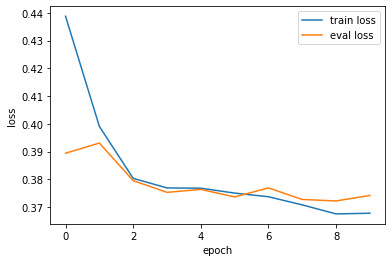

In [28]:
# draw training curve
import matplotlib.pyplot as plt

plt.figure()
x = list(range(len(train_losses)))
plt.plot(x, train_losses)
plt.plot(x, eval_losses)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [29]:
test_df = test_df.sort_values(by=['meanGrade'])
n_samples = test_df.shape[0]
test10 = pd.concat([test_df[:int(0.1*n_samples)], test_df[int(0.9*n_samples):]], ignore_index=True)
test20 = pd.concat([test_df[:int(0.2*n_samples)], test_df[int(0.8*n_samples):]], ignore_index=True)
test30 = pd.concat([test_df[:int(0.3*n_samples)], test_df[int(0.7*n_samples):]], ignore_index=True)
test40 = pd.concat([test_df[:int(0.4*n_samples)], test_df[int(0.6*n_samples):]], ignore_index=True)

test10_dataset = Task1Dataset(feature, test10['meanGrade'])
test20_dataset = Task1Dataset(feature, test20['meanGrade'])
test30_dataset = Task1Dataset(feature, test30['meanGrade'])
test40_dataset = Task1Dataset(feature, test40['meanGrade'])

test_loader10 = torch.utils.data.DataLoader(test10_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader20 = torch.utils.data.DataLoader(test20_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader30 = torch.utils.data.DataLoader(test30_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader40 = torch.utils.data.DataLoader(test40_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
loaders = [test_loader, test_loader10, test_loader20, test_loader30, test_loader40]

#test_loss, test_mse, __, __ = eval(test_loader10, model)
for i, loader in enumerate(loaders):
    test_loss, test_mse, __, __ = eval(loader, model, 'attn')
    if i == 0:
        print('whole test data, test loss{:.6f}, test rmse{:.6f}'.format(test_loss, test_mse**0.5))
    else:
        print('{:2f} test data, test loss{:.6f}, test rmse{:.6f}'.format(0.1*i, test_loss, test_mse**0.5))

whole test data, test loss0.381673, test rmse0.617797
0.100000 test data, test loss0.950547, test rmse0.974960
0.200000 test data, test loss0.673055, test rmse0.820399
0.300000 test data, test loss0.549968, test rmse0.741598
0.400000 test data, test loss0.457464, test rmse0.676361


# Part 1 Second Experiment

In [ ]:
MaxLen = 40

# create dataloader
def create_dataloader(df):
    data = df['edited']
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    data_tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    data_tokenized = pad_sequences(data_tokenized, maxlen=MaxLen, dtype='long', value=0, truncating='post')
    print('setence tokenized and padded.')
    attention_mask = []
    for token in data_tokenized:
        att_mask = [int(token_id > 0) for token_id in token]
        attention_mask.append(att_mask)

    data_tokenized = torch.tensor(data_tokenized)
    label = torch.tensor(df['meanGrade'].values, dtype=torch.float32)
    attention_mask = torch.tensor(attention_mask, dtype=torch.int32)
    dataset = Task1DatasetBert(data_tokenized, label, attention_mask)
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
    print('data loader created.')
    return loader

train_loader = create_dataloader(train_df)
dev_loader = create_dataloader(dev_df)
test_loader = create_dataloader(test_df)


setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.


In [ ]:
# define and train model
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                   num_labels=1,
                                                                   output_attentions=False,
                                                                   output_hidden_states=False)
model.hidden_dropout_prob = 0.3
model.attention_dropout_prob = 0.3
model.cuda()

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.03)

train(train_loader, dev_loader, model, epochs, 'bert')


setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |             Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.57 |             Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 04 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 06 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |             Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 08 | Train Loss: 0.32 |

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                   num_labels=1,
                                                                   output_attentions=False,
                                                                   output_hidden_states=False)
model.load_state_dict(torch.load('./drive/MyDrive/NLP_CW/bert.pth'))
model.to(device)
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

test_df = test_df.sort_values(by=['meanGrade'])
n_samples = test_df.shape[0]
test10 = pd.concat([test_df[:int(0.1*n_samples)], test_df[int(0.9*n_samples):]])
test20 = pd.concat([test_df[:int(0.2*n_samples)], test_df[int(0.8*n_samples):]])
test30 = pd.concat([test_df[:int(0.3*n_samples)], test_df[int(0.7*n_samples):]])
test40 = pd.concat([test_df[:int(0.4*n_samples)], test_df[int(0.6*n_samples):]])

test_loader10 = create_dataloader(test10)
test_loader20 = create_dataloader(test20)
test_loader30 = create_dataloader(test30)
test_loader40 = create_dataloader(test40)
loaders = [test_loader, test_loader10, test_loader20, test_loader30, test_loader40]
for i, loader in enumerate(loaders):
    test_loss, test_mse, __, __ = eval(loader, model, 'bert')
    if i == 0:
        print('whole test data, test loss{:.6f}, test rmse{:.6f}'.format(test_loss, test_mse**0.5))
    else:
        print('{:2f} test data, test loss{:.6f}, test rmse{:.6f}'.format(0.1*i, test_loss, test_mse**0.5))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
whole test data, test loss0.317227, test rmse0.563229
0.100000 test data, test loss0.879384, test rmse0.937755
0.200000 test data, test loss0.630693, test rmse0.794162
0.300000 test data, test loss0.483561, test rmse0.695385
0.400000 test data, test loss0.386061, test rmse0.621338


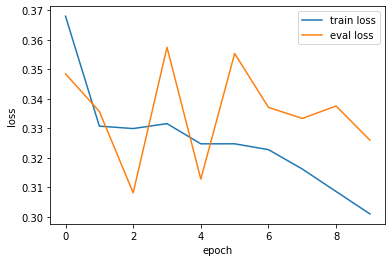

In [ ]:
# draw training curve
import matplotlib.pyplot as plt
plt.figure()
train_loss = np.load('./drive/MyDrive/NLP_CW/train_loss.npy')
eval_loss = np.load('./drive/MyDrive/NLP_CW/eval_loss.npy')
x = list(range(len(train_loss)))
plt.plot(x, train_loss)
plt.plot(x, eval_loss)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |


## Install required packages

In [ ]:
!pip install tqdm
!pip install gensim

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords 

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import re

from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load the data

In [7]:
# Load data from local
train_df = pd.read_csv('./dataset/train.csv')
dev_df = pd.read_csv('./dataset/dev.csv')
test_df = pd.read_csv('./dataset/test.csv')
edited_train_df = get_edited_df(train_df)
edited_dev_df = get_edited_df(dev_df)
edited_test_df = get_edited_df(test_df)

In [8]:
training_x = edited_train_df['edited']
dev_x = edited_dev_df['edited']
training_y= edited_train_df['meanGrade']
dev_y = edited_dev_df['meanGrade']

### Helper Functions

In [16]:
def get_tokenized_corpus(corpus):
    """
    Return a list of tokenized sentences
    """
    # tokenized the sentence
    tokenized_sentence = [word_tokenize(s) for s in corpus] # list of list of sentences
    
    # remove the stop words
    stop_words = set(stopwords.words('english'))
    tokenized_sentence_filtered = []
    # Lemmatizing and removing stopwords
    for s in tokenized_sentence:
        tokenized_sentence_filtered.append([WordNetLemmatizer().lemmatize(w.lower(), 'v') for w in s if w not in stop_words])
    return tokenized_sentence_filtered

In [17]:
def load_data(data, context_size, subsampling=False, sampling_rate=1e-5):
    """ Load a list of sentenses and return the training pairs after data preprocessing
        
    :param data: Input list of sentences
    :param context_size: Window size for skip gram model
    :param subsampling: bool
    :param sampling_rate: subsampling rate
          
    :return train_idx_pairs: list of word pairs
    :return vocabulary: dictionary of vocabulary
    :return w2i: dictionary, word to index
    :return i2w: dictionary, index to word
    """
    # tokenized the sentence
    tokenized_sentence = [word_tokenize(s) for s in data] # list of list of sentences
    
    # remove the stop words
    stop_words = set(stopwords.words('english'))
    tokenized_sentence_filtered = []
    # Lemmatizing and removing stopwords
    print("Lemmatize and remove stopwords")
    for s in tqdm(tokenized_sentence):
        tokenized_sentence_filtered.append([WordNetLemmatizer().lemmatize(w.lower(), 'v') for w in s if w not in stop_words])
    
    tokenized_sentence_filtered, vocabulary, w2i, i2w = get_vocab(tokenized_sentence_filtered, subsampling=subsampling, sampling_rate=sampling_rate)
    train_idx_pairs = get_idx_pairs(tokenized_sentence_filtered, w2i, context_size=context_size)
    
    return train_idx_pairs, vocabulary, w2i, i2w

In [18]:
def get_vocab(tokenized_sentence, subsampling, sampling_rate):
    """
    Build vocabulary and perform subsampling
    
    """
    vocabulary = {}
    w2i = {}
    i2w = {}
    n_words = 0.0

    # Build vocabulary
    print("Building vocabulary ...")
    for sentence in tqdm(tokenized_sentence):
        for token in sentence:
            if token not in vocabulary:
                vocabulary[token] = 0
                i2w[len(w2i)] = token
                w2i[token] = len(w2i)
            vocabulary[token] += 1
            n_words += 1
            
    if subsampling:
        sub_tokenized_sentence = []
        for sentence in tokenized_sentence:
            subsampling_s = []
            for i, token in enumerate(sentence):
                freq = vocabulary[token] / n_words
                p_w = 1 - np.sqrt(sampling_rate/freq)
                
                sampling = np.random.sample() # Return random floats in the half-open interval [0.0, 1.0)
                if sampling > p_w: # if sampling < p_w, remove the token
                    subsampling_s.append(token)
            sub_tokenized_sentence.append(subsampling_s)
        tokenized_sentence = sub_tokenized_sentence
        
    return tokenized_sentence, vocabulary, w2i, i2w

In [19]:
def get_idx_pairs(tokenized_sentence, w2i, context_size):
    """
    return a list of [center_word, target_word] pairs
    
    """
    
    train_dat = []
    vocab_idx = list(range(len(w2i)))
    
    # Get idx pairs:
    print("Getting index pairs ... ")
    for sentence in tqdm(tokenized_sentence):
        sent_idx = [w2i[word] for word in sentence]
        
        # for each word treated as center word
        for c_pos in range(len(sent_idx)):
            # for each window position
            for window in range(-context_size, context_size+1):
                tar_pos = c_pos + window
                if tar_pos < 0 or tar_pos >= len(sent_idx) or tar_pos == c_pos:
                    continue
                
                cen_word_idx = sent_idx[c_pos]
                tar_word_idx = sent_idx[tar_pos]
                train_dat.append([cen_word_idx, tar_word_idx])
                
    return train_dat

In [33]:
def get_noise_dist(vocabulary):
    """
    Build noise dist for negative sampling
    """
    word_freqs = np.array(list(vocabulary.values()))
    unigram_dist = word_freqs/sum(word_freqs)
    noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))
    return noise_dist

### word2vec dataset

In [21]:
class Word2vecDataset(Dataset):
    """
    Build dataset for word2vec
    """
    def __init__(self, train_data, vocabulary, word2idx, idx2word):
        self.data = torch.tensor(train_data, dtype=torch.long)
        self.vocabulary = vocabulary
        self.w2i = word2idx
        self.i2w = idx2word

    def __getitem__(self, index):
        x = self.data[index, 0]
        y = self.data[index, 1]
        return x, y

    def __len__(self):
        return len(self.data)

### Skip-gram model

In [22]:
class SkipGram(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, device, negative_sampling=False, noise_dist=None, negative_samples=5):
        super(SkipGram, self).__init__()
        
        self.embed_input = nn.Embedding(vocab_size, embedding_size)
        self.embed_context = nn.Embedding(vocab_size, embedding_size)
        
        self.vocab_size = vocab_size
        self.device = device
        self.negative_sampling = negative_sampling
        self.negative_samples = negative_samples
        self.noise_dist = noise_dist
        
        # Initialize both embedding tables with uniform distribution
        self.embed_input.weight.data.uniform_(-1,1)
        self.embed_context.weight.data.uniform_(-1,1)
        
    def forward(self, center_word, context_word):
        emb_input = self.embed_input(center_word)
        emb_context = self.embed_context(context_word)
        out = torch.mul(emb_input, emb_context)
        out = torch.sum(out, dim=1)
        out_loss = F.logsigmoid(out)
        
        if self.negative_sampling:
            if self.noise_dist is None:
                noise_dist = torch.ones(self.vocab_size)  
            else:
                noise_dist = self.noise_dist
                
            num_neg_samples = context_word.shape[0]*self.negative_samples
            negative_example = torch.multinomial(noise_dist, num_neg_samples, replacement = True)
            negative_example = negative_example.view(context_word.shape[0], self.negative_samples).to(self.device)
            emb_negative = self.embed_context(negative_example)
            
            emb_product_neg_samples = torch.bmm(emb_negative.neg(), emb_input.unsqueeze(2)) # b * negative_samples * 1
            noise_loss = F.logsigmoid(emb_product_neg_samples).squeeze(2).sum(1)
            
            total_loss = -(out_loss + noise_loss).mean()
            
            return total_loss
        
        else:
            total_loss = -(out_loss).mean()
            return total_loss

In [23]:
def train_w2v(model, optimizer, NUM_EPOCHS, DEVICE, train_loader):
    losses = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        print('\n----- EPOCH {}/{} -----'.format(epoch + 1, NUM_EPOCHS))    

        # model.train()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            model.train()
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            loss = model(x_batch, y_batch)

            loss.backward()
            optimizer.step()    

            losses.append(loss.item())

            if batch_idx % 1000 == 0:
                print(f'Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')    

### bi-Gru

In [24]:
class GRU(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):

        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)
        # sequence_len,batch_size, embedding_dim
        gru_out, self.hidden = self.gru(embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)
        out = self.hidden2label(gru_out[-1])
        
        return out

In [25]:
def create_gru_dataloader(train_x, val_x, train_y, val_y, train, word2idx=None, embedding=None,
                          hidden_size=None, batch_size=None, device=None):
    """
    Return dataloader for training bi-GRU model
    """
    if train:
        tokenized_training_x = get_tokenized_corpus(train_x)
        tokenized_dev_x = get_tokenized_corpus(val_x)

        vectorized_seqs_train = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in tokenized_training_x]
        vectorized_seqs_val = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in tokenized_dev_x]

        # To avoid any sentences being empty (if no words match to our word embeddings)
        vectorized_seqs_train = [x if len(x) > 0 else [0] for x in vectorized_seqs_train]
        vectorized_seqs_val = [x if len(x) > 0 else [0] for x in vectorized_seqs_val]

        INPUT_DIM = len(word2idx)
        EMBEDDING_DIM = embedding.shape[1]
        HIDDEN_DIM = hidden_size
        BATCH_SIZE = batch_size

        gru_model = GRU(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, BATCH_SIZE, device)
        print("Model initialised.")

        gru_model.to(device)
        # We provide the model with our embeddings
        gru_model.embedding.weight.data.copy_(embedding)


        train_dataset = Task1Dataset(vectorized_seqs_train, train_y.to_numpy())
        dev_dataset = Task1Dataset(vectorized_seqs_val, val_y.to_numpy())

        train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
        dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

        print("Dataloaders created.")
        return gru_model, train_loader, dev_loader
    else:
        # testing
        BATCH_SIZE = batch_size
        tokenized_dev_x = get_tokenized_corpus(val_x)
        
        vectorized_seqs_val = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in tokenized_dev_x]
        
        vectorized_seqs_val = [x if len(x) > 0 else [0] for x in vectorized_seqs_val]
        
        dev_dataset = Task1Dataset(vectorized_seqs_val, val_y)
        
        dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
        
        return dev_loader

## 2-1 Training word-embedding on train+val dataset

In [28]:
# Prepare for training set
input_data = pd.concat([training_x, dev_x]).values.tolist()
train_idx_pairs, vocabulary, w2i, i2w = load_data(input_data, context_size=5, subsampling=False)
train_dataset = Word2vecDataset(train_idx_pairs, vocabulary, w2i, i2w)

Lemmatize and remove stopwords


  0%|          | 0/20319 [00:00<?, ?it/s]

Building vocabulary ...


  0%|          | 0/20319 [00:00<?, ?it/s]

Getting index pairs ... 


  0%|          | 0/20319 [00:00<?, ?it/s]

In [32]:
# Print the dataset info
vocab = train_dataset.vocabulary
word_to_ix = train_dataset.w2i
ix_to_word = train_dataset.i2w
noise_dist = get_noise_dist(vocab)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 512, shuffle=True)

print('len(train_dataset): ', len(train_dataset))
print('len(train_loader): ', len(train_loader))
print('len(vocab): ', len(vocab), '\n')

len(train_dataset):  1460444
len(train_loader):  2853
len(vocab):  14915 



In [ ]:
# Initialise Skip-gram model
sg_model = SkipGram(100, len(vocab), device, negative_sampling=True, noise_dist=noise_dist, negative_samples=15).to(device)
sg_optimizer = torch.optim.Adam(sg_model.parameters())
print(sg_model)

SkipGram(
  (embed_input): Embedding(14915, 100)
  (embed_context): Embedding(14915, 100)
)


Start training

In [ ]:
train_w2v(model=sg_model, optimizer=sg_optimizer, NUM_EPOCHS=10, DEVICE=device, train_loader=train_loader)

  0%|          | 0/10 [00:00<?, ?it/s]


----- EPOCH 1/10 -----
Batch: 1/2853, Loss: 24.303386688232422
Batch: 1001/2853, Loss: 15.333587646484375
Batch: 2001/2853, Loss: 8.393190383911133

----- EPOCH 2/10 -----
Batch: 1/2853, Loss: 5.936496734619141
Batch: 1001/2853, Loss: 4.773550033569336
Batch: 2001/2853, Loss: 4.363983631134033

----- EPOCH 3/10 -----
Batch: 1/2853, Loss: 4.1367034912109375
Batch: 1001/2853, Loss: 3.8732213973999023
Batch: 2001/2853, Loss: 3.815312385559082

----- EPOCH 4/10 -----
Batch: 1/2853, Loss: 3.57132887840271
Batch: 1001/2853, Loss: 3.483257532119751
Batch: 2001/2853, Loss: 3.4256818294525146

----- EPOCH 5/10 -----
Batch: 1/2853, Loss: 3.3023521900177
Batch: 1001/2853, Loss: 3.2651190757751465
Batch: 2001/2853, Loss: 3.292302370071411

----- EPOCH 6/10 -----
Batch: 1/2853, Loss: 3.103996992111206
Batch: 1001/2853, Loss: 3.117640972137451
Batch: 2001/2853, Loss: 3.008286714553833

----- EPOCH 7/10 -----
Batch: 1/2853, Loss: 2.8872735500335693
Batch: 1001/2853, Loss: 2.9114251136779785
Batch: 2

In [ ]:
EMBEDDINGS_1 = sg_model.embed_input.weight.data
print('EMBEDDINGS.shape: ', EMBEDDINGS_1.shape)

EMBEDDINGS.shape:  torch.Size([14915, 100])


In [ ]:
# Save the model
# torch.save(sg_model.state_dict(), 'w2v_origin.pt')

#### Train bi-Gru Model

In [ ]:
epochs = 10
batch_size = 64
hidden_dim = 50
filename = ['./results/train_loss_1.npy', './results/val_loss_1.npy']
is_train = True
gru_model, train_loader, dev_loader = create_gru_dataloader(training_x, dev_x, training_y, dev_y, is_train, w2i, EMBEDDINGS_1, hidden_dim, batch_size, device)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.0001)

train(train_loader, dev_loader, gru_model, epochs, filename=filename)

Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.58 | Train MSE: 0.58 | Train RMSE: 0.76 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.60 |
| Epoch: 02 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.60 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.60 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE:

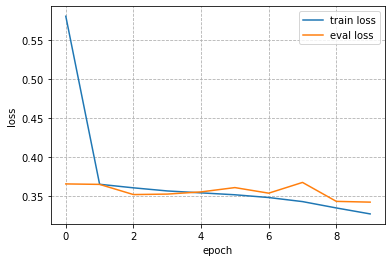

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the loss
import matplotlib.pyplot as plt

plt.figure()
train_loss = np.load('./results/train_loss_1.npy')
eval_loss = np.load('./results/val_loss_1.npy')
x = list(range(len(train_loss)))
plt.plot(x, train_loss)
plt.plot(x, eval_loss)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(linestyle='--')
plt.show()
plt.savefig('./results/bigru-1.jpg')

### Performance on the test set

In [ ]:
test_df = edited_test_df.sort_values(by=['meanGrade'])
test_x = test_df['edited']
test_y = test_df['meanGrade']
n_samples = edited_test_df.shape[0]
print('Number of the test samples: {}'.format(n_samples))

test10 = pd.concat([test_df[:int(0.1*n_samples)], test_df[int(0.9*n_samples):]], ignore_index=True)
test20 = pd.concat([test_df[:int(0.2*n_samples)], test_df[int(0.8*n_samples):]], ignore_index=True)
test30 = pd.concat([test_df[:int(0.3*n_samples)], test_df[int(0.7*n_samples):]], ignore_index=True)
test40 = pd.concat([test_df[:int(0.4*n_samples)], test_df[int(0.6*n_samples):]], ignore_index=True)

test_loader = create_gru_dataloader(None, test_x, None, test_y, train=False, word2idx=w2i, batch_size=128)
test_loader10 = create_gru_dataloader(None, test10['edited'], None, test10['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader20 = create_gru_dataloader(None, test20['edited'], None, test20['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader30 = create_gru_dataloader(None, test30['edited'], None, test30['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader40 = create_gru_dataloader(None, test40['edited'], None, test40['meanGrade'], train=False, word2idx=w2i, batch_size=128)

loaders = [test_loader, test_loader10, test_loader20, test_loader30, test_loader40]

for i, loader in enumerate(loaders):
    test_loss, test_mse, __, __ = eval(loader, gru_model)
    if i == 0:
        print('whole test data, test loss {:.6f}, test rmse {:.6f}'.format(test_loss, test_mse**0.5))
    else:
        print('{:2f} test data, test loss {:.6f}, test rmse {:.6f}'.format(0.1*i, test_loss, test_mse**0.5))

Number of the test samples: 3024
whole test data, test loss 0.354736, test rmse 0.595597
0.100000 test data, test loss 0.918842, test rmse 0.958563
0.200000 test data, test loss 0.664310, test rmse 0.815052
0.300000 test data, test loss 0.509828, test rmse 0.714023
0.400000 test data, test loss 0.404516, test rmse 0.636016


## Train the embedding on larger dataset

Hlper function to pre-process text8 dataset

In [26]:
from collections import Counter
import gensim.downloader as api

def process_text8(fraction_data):
    dataset = api.load("text8")
    data = [d for d in dataset][:int(fraction_data*len([d_ for d_ in dataset]))]
    print(f'fraction of data taken: {fraction_data}/1')

    sents = []
    for d in tqdm(data):
        sents.append(' '.join(d))
    return sents

In [29]:
text8 = process_text8(fraction_data=0.2)
total = text8 + input_data
print(len(total))

fraction of data taken: 0.2/1


  0%|          | 0/340 [00:00<?, ?it/s]

20659


### Train the skip-gram model

In [30]:
train_idx_pairs_2, vocabulary_2, w2i_2, i2w_2 = load_data(total, context_size=5, subsampling=True, sampling_rate=1e-5)
train_dataset_2 = Word2vecDataset(train_idx_pairs_2, vocabulary_2, w2i_2, i2w_2)

vocab_2 = train_dataset_2.vocabulary
word_to_ix_2 = train_dataset_2.w2i
ix_to_word_2 = train_dataset_2.i2w

train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size = 1024, shuffle=True)

print('len(train_dataset): ', len(train_dataset_2))
print('len(train_loader): ', len(train_loader_2))
print('len(vocab): ', len(vocab_2), '\n')

Lemmatize and remove stopwords


  0%|          | 0/20659 [00:00<?, ?it/s]

Building vocabulary ...


  0%|          | 0/20659 [00:00<?, ?it/s]

Getting index pairs ... 


  0%|          | 0/20659 [00:00<?, ?it/s]

len(train_dataset):  7516988
len(train_loader):  7341
len(vocab):  97090 



In [34]:
noise_dist_2 = get_noise_dist(vocab_2)
sg_model_2 = SkipGram(100, len(vocab_2), device, negative_sampling=True, noise_dist=noise_dist_2, negative_samples=15).to(device)
print(sg_model_2)
sg_optimizer_2 = torch.optim.Adam(sg_model_2.parameters())

SkipGram(
  (embed_input): Embedding(97090, 100)
  (embed_context): Embedding(97090, 100)
)


In [35]:
train_w2v(model=sg_model_2, optimizer=sg_optimizer_2, NUM_EPOCHS=10, DEVICE=device, train_loader=train_loader_2)

  0%|          | 0/10 [00:00<?, ?it/s]


----- EPOCH 1/10 -----
Batch: 1/7341, Loss: 23.91849136352539
Batch: 1001/7341, Loss: 20.91864013671875
Batch: 2001/7341, Loss: 17.07882308959961
Batch: 3001/7341, Loss: 11.770743370056152
Batch: 4001/7341, Loss: 8.916692733764648
Batch: 5001/7341, Loss: 6.966709136962891
Batch: 6001/7341, Loss: 5.8596954345703125
Batch: 7001/7341, Loss: 5.186636447906494

----- EPOCH 2/10 -----
Batch: 1/7341, Loss: 5.0143327713012695
Batch: 1001/7341, Loss: 4.572483062744141
Batch: 2001/7341, Loss: 4.429664611816406
Batch: 3001/7341, Loss: 4.316624164581299
Batch: 4001/7341, Loss: 4.1544189453125
Batch: 5001/7341, Loss: 4.105058670043945
Batch: 6001/7341, Loss: 3.970726490020752
Batch: 7001/7341, Loss: 3.937100410461426

----- EPOCH 3/10 -----
Batch: 1/7341, Loss: 3.6076204776763916
Batch: 1001/7341, Loss: 3.5502591133117676
Batch: 2001/7341, Loss: 3.5871686935424805
Batch: 3001/7341, Loss: 3.493351936340332
Batch: 4001/7341, Loss: 3.5506932735443115
Batch: 5001/7341, Loss: 3.5082240104675293
Batch: 

In [36]:
EMBEDDINGS_2 = sg_model_2.embed_input.weight.data
print('EMBEDDINGS.shape: ', EMBEDDINGS_2.shape)

EMBEDDINGS.shape:  torch.Size([97090, 100])


In [37]:
# save the embedding
torch.save(sg_model_2.state_dict(), 'w2v_sg_2.pt')

In [48]:
# Train bi-gru model
epochs = 8
batch_size = 64
hidden_dim = 50
filename = ['./results/train_loss_2.npy', './results/val_loss_2.npy']
is_train = True
gru_model_2, train_loader_2, dev_loader_2 = create_gru_dataloader(training_x, dev_x, training_y, dev_y, is_train, w2i_2, EMBEDDINGS_2, hidden_dim, batch_size, device)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(gru_model_2.parameters(), lr=0.0001)

train(train_loader_2, dev_loader_2, gru_model_2, epochs, filename=filename)

Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.51 | Train MSE: 0.51 | Train RMSE: 0.71 |             Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 02 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE:

In [49]:
# save the model
torch.save(gru_model_2.state_dict(), './results/bigru-2.pt')

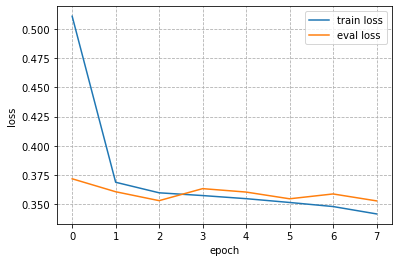

In [52]:
# Plot the loss
import matplotlib.pyplot as plt

plt.figure()
train_loss = np.load('./results/train_loss_2.npy')
eval_loss = np.load('./results/val_loss_2.npy')
x = list(range(len(train_loss)))
plt.plot(x, train_loss)
plt.plot(x, eval_loss)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(linestyle='--')
plt.savefig('./results/bigru-2.png')
plt.show()


### Performance on the test set

In [51]:
test_df = edited_test_df.sort_values(by=['meanGrade'])
test_x = test_df['edited']
test_y = test_df['meanGrade']
n_samples = edited_test_df.shape[0]
print('Number of the test samples: {}'.format(n_samples))

test10 = pd.concat([test_df[:int(0.1*n_samples)], test_df[int(0.9*n_samples):]], ignore_index=True)
test20 = pd.concat([test_df[:int(0.2*n_samples)], test_df[int(0.8*n_samples):]], ignore_index=True)
test30 = pd.concat([test_df[:int(0.3*n_samples)], test_df[int(0.7*n_samples):]], ignore_index=True)
test40 = pd.concat([test_df[:int(0.4*n_samples)], test_df[int(0.6*n_samples):]], ignore_index=True)

test_loader = create_gru_dataloader(None, test_x, None, test_y, train=False, word2idx=w2i, batch_size=128)
test_loader10 = create_gru_dataloader(None, test10['edited'], None, test10['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader20 = create_gru_dataloader(None, test20['edited'], None, test20['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader30 = create_gru_dataloader(None, test30['edited'], None, test30['meanGrade'], train=False, word2idx=w2i, batch_size=128)
test_loader40 = create_gru_dataloader(None, test40['edited'], None, test40['meanGrade'], train=False, word2idx=w2i, batch_size=128)

loaders = [test_loader, test_loader10, test_loader20, test_loader30, test_loader40]

for i, loader in enumerate(loaders):
    test_loss, test_mse, __, __ = eval(loader, gru_model_2)
    if i == 0:
        print('whole test data, test loss {:.6f}, test rmse {:.6f}'.format(test_loss, test_mse**0.5))
    else:
        print('{:2f} test data, test loss {:.6f}, test rmse {:.6f}'.format(0.1*i, test_loss, test_mse**0.5))

Number of the test samples: 3024
whole test data, test loss 0.336131, test rmse 0.579768
0.100000 test data, test loss 0.975938, test rmse 0.987896
0.200000 test data, test loss 0.694871, test rmse 0.833589
0.300000 test data, test loss 0.528296, test rmse 0.726839
0.400000 test data, test loss 0.413420, test rmse 0.642978


### save dictionaries

In [53]:
import pickle

def save_dict(dictionary, filename):
    name = filename + '.pkl'
    a_file = open(name, "wb")
    pickle.dump(dictionary, a_file)
    a_file.close()
    
def load_dict(path):
    a_file = open(path, "rb")
    output = pickle.load(a_file)
    return output

In [54]:
save_dict(vocabulary, './results/vocabulary-1')
save_dict(vocabulary_2, './results/vocabulary-2')
save_dict(w2i, './results/w2i-1')
save_dict(w2i_2, './results/w2i-2')